In [1]:
import functools

import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers
import numpy as np
import numpy as onp

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

In [2]:
def get_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)

    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.2, 1.2, N_test)

    return X[:, None], Y[:, None], X_test[:, None], None

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


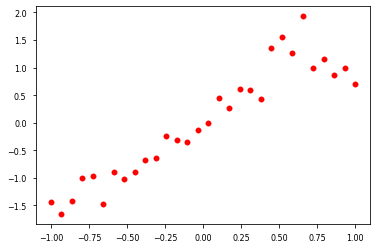

In [3]:
logger.setLevel(logging.INFO)
X, y, Xtest, ytest = get_data()

fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.show()

In [6]:
# squared euclidean distance formula

@jax.jit

def sqe_distance(x,y):
    return jnp.sum((x-y)**2)

@jax.jit # find the packed kernel function

def rbf_kernel(gamma,x,y):
    return jnp.exp(-gamma*sqe_distance(x,y))

def ard_kernel(para,x,y):
    std1 = para[0]
    std2 = para[1]
    var_f = para[2]

    x = x/std1
    y = y/std2

    return var_f*jnp.exp(-sqe_distance(x,y))



In [7]:
# Gram Matrix
def gram(func, params, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(params, x1, y1))(y))(x)

In [8]:
para = 10

# para = np.array([1,1,0.1]) #gamma, var_f, noise

cov_f = functools.partial(gram,rbf_kernel)

K_ = cov_f(para,Xtest,X)

print(K_.shape)

(400, 30)


In [9]:
def zero_mean(x):
    return jnp.zeros(x.shape[0])

In [10]:
def gp_prior(gamma,mu_f,cov_f,x):
    return mu_f(x),cov_f(gamma,x,x) # why are we finding converiance between each pair of test_x?

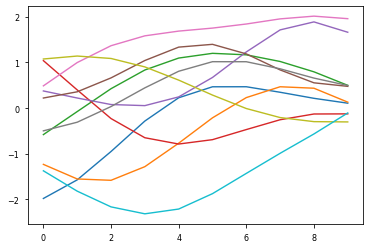

In [12]:
n_samples = 10

test_X = X[:n_samples,:].copy()

mu_f = zero_mean

cov_f = functools.partial(gram,rbf_kernel)

mu_x,cov_x = gp_prior(para,mu_f = mu_f,cov_f = cov_f,x = test_X)

jitter = 1e-6

cov_x_ = cov_x+jitter*jnp.eye(cov_x.shape[0])

n_functions = 10

key = jax.random.PRNGKey(0)

y_samples = jax.random.multivariate_normal(key,mu_x,cov_x_,shape = (n_functions,))

# why the con matrix is the kernel function?

assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)


In [13]:
def cholesky_factor(K,Y):
    L = jax.scipy.linalg.cho_factor(K,lower = True)

    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

In [14]:
jitter = 1e-6

In [15]:
def posterior(para,prior_func,X,Y,X_new,likelihood_noise = False, return_cov = False):  #  calling RBF as the kernel function # X is the measurement data, Y is the measurement data, X_new is the test data
    (mu_func,cov_func) = prior_func

    gamma = para[0] # be careful of this part!!!
    var_f = para[1] # depends on the kernel function that we call, para should be unpacked in different way
    noise = para[2] 

    mu_X, Kxx = gp_prior(gamma,mu_f=mu_func,cov_f = cov_func, x=X)

    # predict mean distribution

    # cholesky factor

    logging.debug(f'CHOL: Y: {Y.shape},{mu_func(X).shape}')

    (L,lower),alpha = cholesky_factor(Kxx + (noise + 1e-7) * jnp.eye(Kxx.shape[0]), Y-mu_func(X).reshape(-1,1)) # is x the same as the training data?

    # 4. predictive mean distribution

    # calculate transform kernel

    KxX = cov_func(gamma,X_new,X)
    # print (KxX)

    mu_y = jnp.dot(KxX, alpha) # does this need to multiply y?

    v = jax.scipy.linalg.cho_solve((L,lower),KxX.T)

    # 5. predictive kernel matrix for inputs

    Kxx = cov_func(gamma,X_new,X_new)

    cov_y = Kxx - jnp.dot(KxX,v)

    # Likelihood noise

    if likelihood_noise is True:
        cov_y += noise
    
    if return_cov is not True:

        cov_y = jnp.diag(cov_y)
    
    return mu_y,cov_y
        





In [16]:
logger.setLevel(logging.INFO)

mu_f = zero_mean

# cov function

para = np.array([1,1,0.01]) #gamma, var_f, noise

cov_f = functools.partial(gram,rbf_kernel)

# simmple sample

test_X = X[0,:]

prior_funcs = (mu_f,cov_f)

logging.info(f"Inputs, X: {X.shape}, Y:{y.shape}, X*={test_X.shape}")

mu_y,cov_y = posterior(para,prior_funcs, X, y ,X_new = test_X)

logging.info(f"inputs, mu_y:{mu_y.shape},cov:{cov_y.shape}")


# Multiple samples

test_X = X
logging.info(f"Inputs, X: {X.shape}, Y:{y.shape}, X*={test_X.shape}")

mu_y,var_y = posterior(para,prior_funcs,X,y,test_X,False,False)
_,cov_y = posterior(para,prior_funcs,X,y,test_X,True,True)

logging.info(f"Outputs, mu_y: {mu_y.shape}, Cov: {cov_y.shape}, Var:{var_y.shape},")

np.testing.assert_array_almost_equal(np.array(jnp.diag(cov_y)), np.array(var_y), decimal=1e-5)


INFO:root:Inputs, X: (30, 1), Y:(30, 1), X*=(1,)
INFO:root:inputs, mu_y:(1, 1),cov:(1,)
INFO:root:Inputs, X: (30, 1), Y:(30, 1), X*=(30, 1)
INFO:root:Outputs, mu_y: (30, 1), Cov: (30, 30), Var:(30,),


In [17]:
def marginal_likelihood(prior_func,para,X_trains,Y_trains):

    mu_f,cov_f = prior_func

    gamma = para[0] # be careful of this part!!!
    # var_f = para[1] # depends on the kernel function that we call, para should be unpacked in different way
    noise = para[1] 

    # gp prior

    mu_x = mu_f(Y_trains)
    logging.debug(f"mu: {mu_x.shape}")

    Kxx = cov_f(gamma,X_trains,X_trains)

    # GP likelihood

    K_gp = Kxx + (noise + 1e-7)*jnp.eye(Kxx.shape[0])

    # log probability

    log_prob = jax.scipy.stats.multivariate_normal.logpdf(x = Y_trains.T,mean = mu_x,cov = K_gp)

    return -log_prob.sum()

In [19]:
X, y, Xtest, ytest = get_data()
test_X = X
test_Y = y
nll = marginal_likelihood(prior_funcs, para, test_X, test_Y)
logging.info(f"NLL: {nll}")

INFO:root:NLL: 33.571327209472656


In [20]:
# Multiple Output Dimensions
X, y, Xtest, ytest = get_data()
test_X = jnp.hstack([X,X])
test_Y = jnp.hstack([y,y])
nll = marginal_likelihood(prior_funcs, para, test_X, test_Y)
logging.info(f"NLL: {nll}")

INFO:root:NLL: 67.88621520996094


In [21]:
def saturate(para):
    return jax.nn.softplus(para)

In [22]:
logger.setLevel(logging.INFO)

X, y, Xtest, ytest = get_data(50)


In [35]:
# prior functions (mean,cov)

mu_f = zero_mean

cov_f = functools.partial(gram, rbf_kernel)

gp_priors = (mu_f,cov_f)

para = np.array([1,0.01])

para = saturate(para)

mll_loss = jax.jit(functools.partial(marginal_likelihood, gp_priors))

# gredient loss function

dloss = jax.jit(jax.grad(mll_loss))

# step function

@jax.jit


def step(para,X,y,step,opt_state):

    # calculate loss

    loss = mll_loss(para,X,y)

    grads= dloss(para,X,y)

    opt_state = opt_update(step,grads,opt_state)

    para = get_para(opt_state)

    return para,opt_state,loss

# Initialise optimizer
opt_init,opt_update,get_para = optimizers.rmsprop(step_size = 1e-2)

# Initialise parameter

opt_state = opt_init(para)

para = get_para(opt_state)

# trainig parameters

n_epochs = 1000

learning_rate = 0.1

losses = []

new_para = np.zeros(2)

import tqdm

with tqdm.trange(n_epochs) as bar:

    for i in bar:
        para, opt_state, value = step(para, X, y,i, opt_state)

        # update para

        for i in range((para.shape[0])):
            new_para[i] = jax.nn.softplus(para[i])
        
        losses.append(value)

        # bar.set_postfix(losses)

        para = saturate(para)
        







100%|██████████| 1000/1000 [00:01<00:00, 919.46it/s]


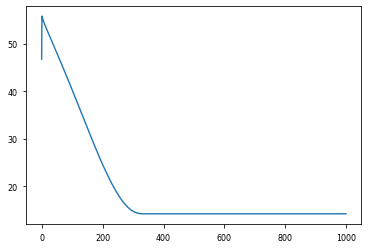

In [36]:
plt.plot(losses)

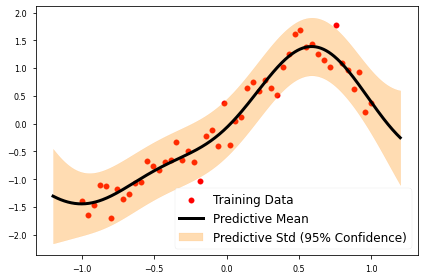

In [37]:
mu_y, var_y = posterior(para, gp_priors, X, y, Xtest, True, False)

uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())


fig, ax = plt.subplots()
ax.scatter(X, y, c='red', label='Training Data')
plt.plot(Xtest.squeeze(), mu_y.squeeze(), label=r'Predictive Mean', color='black', linewidth=3)
plt.fill_between(
    Xtest.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, 
    alpha=0.3,
    color='darkorange',
    label=f"Predictive Std (95% Confidence)"
    )
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()